In [4]:
#pip install pyarrow fastparquet


Note: you may need to restart the kernel to use updated packages.


In [1]:
from typing import List, Union, Optional
from pathlib import Path
from datetime import date, datetime
import requests
import pandas as pd
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


class PowerAPI:
    """
    Query the NASA Power API.
    Check https://power.larc.nasa.gov/ for documentation
    Attributes
    ----------
    url : str
        Base URL
    """
    url = "https://power.larc.nasa.gov/api/temporal/daily/point?"

    def __init__(self,
                 start: Union[date, datetime, pd.Timestamp],
                 end: Union[date, datetime, pd.Timestamp],
                 long: float, lat: float,
                 use_long_names: bool = False,
                 parameter: Optional[List[str]] = None):
        """
        Parameters
        ----------
        start: Union[date, datetime, pd.Timestamp]
        end: Union[date, datetime, pd.Timestamp]
        long: float
            Longitude as float
        lat: float
            Latitude as float
        use_long_names: bool
            NASA provides both identifier and human-readable names for the fields. If set to True this will parse
            the data with the latter
        parameter: Optional[List[str]]
            List with the parameters to query.
            Default is ['T2M_RANGE', 'TS', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M', 'QV2M', 'RH2M',
                        'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX',
                        'WS50M_MIN', 'WS50M_RANGE']
        """
        self.start = start
        self.end = end
        self.long = long
        self.lat = lat
        self.use_long_names = use_long_names
        if parameter is None:
            self.parameter = ['T2M_RANGE', 'TS', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M', 'QV2M', 'RH2M',
                              'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX',
                              'WS50M_MIN', 'WS50M_RANGE']

        self.request = self._build_request()

    def _build_request(self) -> str:
        """
        Build the request
        Returns
        -------
        str
            Full request including parameter
        """
        r = self.url
        r += f"parameters={(',').join(self.parameter)}"
        r += '&community=RE'
        r += f"&longitude={self.long}"
        r += f"&latitude={self.lat}"
        r += f"&start={self.start.strftime('%Y%m%d')}"
        r += f"&end={self.end.strftime('%Y%m%d')}"
        r += '&format=JSON'

        return r

    def get_weather(self) -> pd.DataFrame:
        """
        Main method to query the weather data
        Returns
        -------
        pd.DataFrame
            Pandas DataFrame with DateTimeIndex
        """

        response = requests.get(self.request)

        assert response.status_code == 200

        data_json = response.json()

        records = data_json['properties']['parameter']

        df = pd.DataFrame.from_dict(records)

        return df


The above source code for class PowerAPI to fetch weather data is from this github project:

https://github.com/kdmayer/nasa-power-api/blob/main/src/power_api.py


Fetch major Canadian cities weather data from NASA PowerAPI

In [2]:
import pandas as pd
from datetime import datetime
import requests


cities = {
    'Toronto': {'lat': 43.7, 'lon': -79.42},
    'Vancouver': {'lat': 49.28, 'lon': -123.12},
    'Montreal': {'lat': 45.50, 'lon': -73.58},
    'Calgary': {'lat': 51.05, 'lon': -114.07},
    'Ottawa': {'lat': 45.42, 'lon': -75.69},
    'Edmonton': {'lat': 53.55, 'lon': -113.49},
    'Quebec City': {'lat': 46.81, 'lon': -71.21},
    'Winnipeg': {'lat': 49.89, 'lon': -97.14},
    'Hamilton': {'lat': 43.26, 'lon': -79.87},
    'Halifax': {'lat': 44.65, 'lon': -63.57}
}

# start and end date
start_date = datetime(2014, 1, 1)
end_date = datetime(2024, 12, 31)

# get weather data from NASA Power API
def fetch_weather_data(city_name, lat, lon, start, end):
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,WS10M,WS10M_MAX,WS10M_MIN&community=RE&longitude={lon}&latitude={lat}&start={start.strftime('%Y%m%d')}&end={end.strftime('%Y%m%d')}&format=JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data_json = response.json()
        records = data_json['properties']['parameter']
        df = pd.DataFrame.from_dict(records)
        df['City'] = city_name  # Add city name to DataFrame
        return df
    else:
        print(f"Failed to fetch data for {city_name}")
        return pd.DataFrame()  # Return an empty DataFrame in case of failure

# collect data for all cities
all_data = []
for city, coords in cities.items():
    city_data = fetch_weather_data(city, coords['lat'], coords['lon'], start_date, end_date)
    if not city_data.empty:
        all_data.append(city_data)


final_df = pd.concat(all_data, ignore_index=True)


print(final_df.head())

# Save to CSV 
final_df.to_csv('canada_weather_data.csv', index=False)


     T2M  T2M_MAX  T2M_MIN  PRECTOTCORR  WS10M  WS10M_MAX  WS10M_MIN     City
0  -8.55    -7.59    -9.48         0.60   5.64       9.39       2.76  Toronto
1 -12.79    -9.74   -14.29         3.05  10.02      10.67       8.67  Toronto
2 -14.31    -8.32   -17.98         0.62   5.47       8.85       2.90  Toronto
3  -2.68     0.19    -6.99         0.82  11.08      13.52       6.71  Toronto
4   0.31     2.14    -0.47         5.82   4.70       7.99       2.57  Toronto


In [3]:
print(len(final_df))


40180


In [4]:
print(final_df.duplicated().sum())
#no overlapping data fetched multiple times

0


EDA 

In [5]:
weather = pd.read_csv('canada_weather_data.csv')
#extracting saved data from dataset for reproducability

In [6]:

print(len(weather))


40180


In [7]:
weather.head()

,T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,WS10M,WS10M_MAX,WS10M_MIN,City
0,-8.55,-7.59,-9.48,0.60,5.64,9.39,2.76,Toronto
1,-12.79,-9.74,-14.29,3.05,10.02,10.67,8.67,Toronto
2,-14.31,-8.32,-17.98,0.62,5.47,8.85,2.90,Toronto
3,-2.68,0.19,-6.99,0.82,11.08,13.52,6.71,Toronto
4,0.31,2.14,-0.47,5.82,4.70,7.99,2.57,Toronto


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40180 entries, 0 to 40179
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   T2M          40180 non-null  float64
 1   T2M_MAX      40180 non-null  float64
 2   T2M_MIN      40180 non-null  float64
 3   PRECTOTCORR  40180 non-null  float64
 4   WS10M        40180 non-null  float64
 5   WS10M_MAX    40180 non-null  float64
 6   WS10M_MIN    40180 non-null  float64
 7   City         40180 non-null  object 
dtypes: float64(7), object(1)
memory usage: 2.5+ MB


In [9]:
weather['City'].value_counts()

City
Toronto        4018
Vancouver      4018
Montreal       4018
Calgary        4018
Ottawa         4018
Edmonton       4018
Quebec City    4018
Winnipeg       4018
Hamilton       4018
Halifax        4018
Name: count, dtype: int64

In [11]:
weather.describe()

,T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,WS10M,WS10M_MAX,WS10M_MIN
count,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000
mean,6.103174,10.559486,1.613913,2.713427,3.811629,5.547094,2.054852
std,11.479135,11.933006,11.450045,5.721862,1.940939,2.700472,1.466334
min,-38.570000,-32.690000,-44.470000,0.000000,0.430000,0.850000,0.010000
25%,-1.440000,1.630000,-4.960000,0.120000,2.340000,3.460000,0.960000
50%,6.510000,11.080000,2.290000,0.600000,3.440000,5.040000,1.785000
75%,15.820000,20.730000,10.780000,2.490000,4.870000,7.120000,2.800000
max,30.360000,38.490000,25.180000,94.200000,18.580000,22.200000,15.860000


In [18]:
#meaningful column names
weather.rename(columns={
    'T2M': 'Temperature (°C)',
    'T2M_MAX': 'Max Temperature (°C)',
    'T2M_MIN': 'Min Temperature (°C)',
    'PRECTOTCORR': 'Precipitation (mm)',
    'WS10M': 'Wind Speed (m/s)',
    'WS10M_MAX': 'Max Wind Speed (m/s)',
    'WS10M_MIN': 'Min Wind Speed (m/s)'
}, inplace=True)


print(weather.head())


   Temperature (°C)  Max Temperature (°C)  Min Temperature (°C)  Precipitation (mm)  Wind Speed (m/s)  Max Wind Speed (m/s)  Min Wind Speed (m/s)     City
0             -8.55                 -7.59                 -9.48                0.60              5.64                  9.39                  2.76  Toronto
1            -12.79                 -9.74                -14.29                3.05             10.02                 10.67                  8.67  Toronto
2            -14.31                 -8.32                -17.98                0.62              5.47                  8.85                  2.90  Toronto
3             -2.68                  0.19                 -6.99                0.82             11.08                 13.52                  6.71  Toronto
4              0.31                  2.14                 -0.47                5.82              4.70                  7.99                  2.57  Toronto


In [ ]:
#THIS DATA DOES NOT CONTAIN THE DATE TIME COLUMN ATTACHED TO IT
#ADDING DATE AND TIME COLUMN 

In [12]:
import pandas as pd


start_date = "2014-01-01"
end_date = "2024-12-31"


dates = pd.date_range(start=start_date, end=end_date)
num_days = len(dates)


cities = ['Toronto', 'Vancouver', 'Montreal', 'Calgary', 'Ottawa',
          'Edmonton', 'Quebec City', 'Winnipeg', 'Hamilton', 'Halifax']

num_cities = len(cities)


expected_rows = num_days * num_cities
print(f"Expected number of rows: {expected_rows}")


if weather.shape[0] > expected_rows:
    # remove excess rows
    weather = weather.iloc[:expected_rows]
elif weather.shape[0] < expected_rows:
    # else expand data by repeating it
    repeat_factor = -(-expected_rows // weather.shape[0])  # Ceiling division
    weather = pd.concat([weather] * repeat_factor, ignore_index=True).iloc[:expected_rows]


date_repeated = dates.repeat(num_cities)
city_repeated = cities * num_days


weather['Date'] = date_repeated
weather['City'] = city_repeated


weather.rename(columns={
    'T2M': 'Temperature (°C)',
    'T2M_MAX': 'Max Temperature (°C)',
    'T2M_MIN': 'Min Temperature (°C)',
    'PRECTOTCORR': 'Precipitation (mm)',
    'WS10M': 'Wind Speed (m/s)',
    'WS10M_MAX': 'Max Wind Speed (m/s)',
    'WS10M_MIN': 'Min Wind Speed (m/s)'
}, inplace=True)


weather = weather[['Date', 'City', 'Temperature (°C)', 'Max Temperature (°C)',
                   'Min Temperature (°C)', 'Precipitation (mm)',
                   'Wind Speed (m/s)', 'Max Wind Speed (m/s)',
                   'Min Wind Speed (m/s)']]

# Save to a new Excel file
weather.to_excel("weather_with_dates_and_cities.xlsx", index=False)

# Check the updated DataFrame
print(weather.head(20))


Expected number of rows: 40180
         Date         City  Temperature (°C)  Max Temperature (°C)  Min Temperature (°C)  Precipitation (mm)  Wind Speed (m/s)  Max Wind Speed (m/s)  Min Wind Speed (m/s)
0  2014-01-01      Toronto             -8.55                 -7.59                 -9.48                0.60              5.64                  9.39                  2.76
1  2014-01-01    Vancouver            -12.79                 -9.74                -14.29                3.05             10.02                 10.67                  8.67
2  2014-01-01     Montreal            -14.31                 -8.32                -17.98                0.62              5.47                  8.85                  2.90
3  2014-01-01      Calgary             -2.68                  0.19                 -6.99                0.82             11.08                 13.52                  6.71
4  2014-01-01       Ottawa              0.31                  2.14                 -0.47                5.82      

In [13]:
print(weather['Date'].min(), weather['Date'].max())
#confirming that temperature collected over 10 years between 2014 to 2024

2014-01-01 00:00:00 2024-12-31 00:00:00


In [14]:
#repeating eda steps for confirmation
weather.info()
#no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40180 entries, 0 to 40179
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  40180 non-null  datetime64[ns]
 1   City                  40180 non-null  object        
 2   Temperature (°C)      40180 non-null  float64       
 3   Max Temperature (°C)  40180 non-null  float64       
 4   Min Temperature (°C)  40180 non-null  float64       
 5   Precipitation (mm)    40180 non-null  float64       
 6   Wind Speed (m/s)      40180 non-null  float64       
 7   Max Wind Speed (m/s)  40180 non-null  float64       
 8   Min Wind Speed (m/s)  40180 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 2.8+ MB


NOTE:
-Skewness affects models that assume normal distribution (ARIMA, LINEAR REGRESSION, NEURAL NETWORKS)
-Decision tree models not affected by skewness 
- test different models, ARIMA and random forest and gradient boosting with different tranformations and test accuracy with time-based train/test split
- check stationarity

Fetching solar irradiance data for the same cities over the same years

In [15]:
import requests
import pandas as pd
from datetime import datetime


cities = {
    'Toronto': {'lat': 43.7, 'lon': -79.42},
    'Vancouver': {'lat': 49.28, 'lon': -123.12},
    'Montreal': {'lat': 45.50, 'lon': -73.58},
    'Calgary': {'lat': 51.05, 'lon': -114.07},
    'Ottawa': {'lat': 45.42, 'lon': -75.69},
    'Edmonton': {'lat': 53.55, 'lon': -113.49},
    'Quebec City': {'lat': 46.81, 'lon': -71.21},
    'Winnipeg': {'lat': 49.89, 'lon': -97.14},
    'Hamilton': {'lat': 43.26, 'lon': -79.87},
    'Halifax': {'lat': 44.65, 'lon': -63.57}
}


start_date = datetime(2014, 1, 1)
end_date = datetime(2024, 12, 31)

# function to get solar irradiance data from NASA Power API
def fetch_solar_data(city_name, lat, lon, start, end):
    url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN&community=RE&longitude={lon}&latitude={lat}&start={start.strftime('%Y%m%d')}&end={end.strftime('%Y%m%d')}&format=JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data_json = response.json()
        records = data_json['properties']['parameter']
        df = pd.DataFrame.from_dict(records)
        df['City'] = city_name  
        return df
    else:
        print(f"Failed to fetch data for {city_name}")
        return pd.DataFrame()  


all_data = []
for city, coords in cities.items():
    city_data = fetch_solar_data(city, coords['lat'], coords['lon'], start_date, end_date)
    if not city_data.empty:
        all_data.append(city_data)


final_df5 = pd.concat(all_data, ignore_index=True)


print(final_df5.head())


final_df5.to_csv('solar_irradiance_data_canada.csv', index=False)


   ALLSKY_SFC_SW_DWN     City
0               1.02  Toronto
1               0.55  Toronto
2               1.95  Toronto
3               1.54  Toronto
4               0.52  Toronto


In [16]:
print(len(final_df5))

40180


In [17]:
import pandas as pd


df = pd.read_csv('solar_irradiance_data_canada.csv')


print(f"Initial number of rows: {df.shape[0]}")
print(df.head())


start_date = '2014-01-01'
end_date = '2024-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
num_days = len(date_range)


cities = ['Toronto', 'Vancouver', 'Montreal', 'Calgary', 'Ottawa',
          'Edmonton', 'Quebec City', 'Winnipeg', 'Hamilton', 'Halifax']
num_cities = len(cities)


expected_rows = num_days * num_cities
print(f"Expected number of rows: {expected_rows}")

if df.shape[0] > expected_rows:
    df = df.iloc[:expected_rows]  
elif df.shape[0] < expected_rows:
    
    repeat_factor = -(-expected_rows // df.shape[0])  
    df = pd.concat([df] * repeat_factor, ignore_index=True).iloc[:expected_rows]


date_repeated = date_range.repeat(num_cities)
city_repeated = cities * num_days


df['Date'] = date_repeated
df['City'] = city_repeated

df.rename(columns={'ALLSKY_SFC_SW_DWN': 'Solar Irradiance (W/m²)'}, inplace=True)


df = df[['Date', 'City', 'Solar Irradiance (W/m²)']]


df.to_csv('updated_solar_irradiance_data_with_cities_and_dates.csv', index=False)

print("Updated data saved to 'updated_solar_irradiance_data_with_cities_and_dates.csv'")


Initial number of rows: 40180
   ALLSKY_SFC_SW_DWN     City
0               1.02  Toronto
1               0.55  Toronto
2               1.95  Toronto
3               1.54  Toronto
4               0.52  Toronto
Expected number of rows: 40180
Updated data saved to 'updated_solar_irradiance_data_with_cities_and_dates.csv'


In [18]:
print(len(df))

40180


SOLAR ENERGY PRODUCED IS THROUGH THE FORMULA
Energy Produced (kWh)=Solar Irradiance (W/m²)×Area (m²)×Efficiency×Sunlight Hours (h)/1000

Since I do not have panel area, efficiency and sunlight hours datasets,
I am assuming constants of a panel area of 1 m², an efficiency of 18%, and a seperate function to calculate sunlight hours based on season.


In [19]:
import pandas as pd


df = pd.read_csv('updated_solar_irradiance_data_with_cities_and_dates.csv')


max_irradiance = 1000 
max_sunlight_hours = 12  


df['Date'] = pd.to_datetime(df['Date'])


def calculate_sunlight_hours(row):
    
    month = row['Date'].month
    
   
    if month in [11, 12, 1, 2]:  # Winter months
        sunlight_hours = (row['Solar Irradiance (W/m²)'] / max_irradiance) * 5
    elif month in [3, 4, 5, 9, 10]:  # Spring/Autumn months
        sunlight_hours = (row['Solar Irradiance (W/m²)'] / max_irradiance) * 8
    else:  # Summer months
        sunlight_hours = (row['Solar Irradiance (W/m²)'] / max_irradiance) * 11
        
    # Ensure sunlight hours do not exceed 24
    return min(sunlight_hours, 24)


df['Estimated Sunlight Hours'] = df.apply(calculate_sunlight_hours, axis=1)


df['Estimated Sunlight Hours'] = df['Estimated Sunlight Hours'].clip(0, 24)


df.rename(columns={
    'Solar Irradiance (W/m²)': 'Solar Irradiance (W/m²)', 
    'Estimated Sunlight Hours': 'Sunlight Hours'
}, inplace=True)


df = df[['Date', 'City', 'Solar Irradiance (W/m²)', 'Sunlight Hours']]


df.to_csv('solar_energy_with_cities_and_sunlight_hours.csv', index=False)


print(df[['Date', 'City', 'Solar Irradiance (W/m²)', 'Sunlight Hours']].head())


        Date       City  Solar Irradiance (W/m²)  Sunlight Hours
0 2014-01-01    Toronto                     1.02         0.00510
1 2014-01-01  Vancouver                     0.55         0.00275
2 2014-01-01   Montreal                     1.95         0.00975
3 2014-01-01    Calgary                     1.54         0.00770
4 2014-01-01     Ottawa                     0.52         0.00260


In [20]:
solar_energy_data = df.copy()
#for easier comprehension


In [21]:
print(len(solar_energy_data))

40180


In [22]:

solar_energy_data['Date'] = pd.to_datetime(solar_energy_data['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])


if 'City' not in solar_energy_data.columns or 'City' not in weather.columns:
    raise ValueError("Both dataframes must contain a 'City' column for merging.")


final_data = pd.merge(solar_energy_data, weather, on=['City', 'Date'], how='inner')


print(f"Number of rows in the merged dataframe: {final_data.shape[0]}")


print(final_data.head())


final_data.to_csv('merged_solar_weather_data.csv', index=False)


Number of rows in the merged dataframe: 40180
        Date       City  Solar Irradiance (W/m²)  Sunlight Hours  Temperature (°C)  Max Temperature (°C)  Min Temperature (°C)  Precipitation (mm)  Wind Speed (m/s)  Max Wind Speed (m/s)  Min Wind Speed (m/s)
0 2014-01-01    Toronto                     1.02         0.00510             -8.55                 -7.59                 -9.48                0.60              5.64                  9.39                  2.76
1 2014-01-01  Vancouver                     0.55         0.00275            -12.79                 -9.74                -14.29                3.05             10.02                 10.67                  8.67
2 2014-01-01   Montreal                     1.95         0.00975            -14.31                 -8.32                -17.98                0.62              5.47                  8.85                  2.90
3 2014-01-01    Calgary                     1.54         0.00770             -2.68                  0.19              

In [23]:
print(len(final_data))

40180


In [28]:
# constants for the formula
PANEL_AREA = 20  # m²
EFFICIENCY = 0.2  # 20%

# Add the 'Estimated Solar Energy Consumption' column
final_data['Estimated Solar Energy Consumption (kWh)'] = (
    final_data['Solar Irradiance (W/m²)'] *  # Irradiance in W/m²
    final_data['Sunlight Hours'] *  # Hours
    PANEL_AREA *  # Panel area in m²
    EFFICIENCY / 1000  # Convert from Wh to kWh
)

# Drop target-related columns if needed
columns_to_drop = ['Solar Irradiance (W/m²)', 'Sunlight Hours']
final_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Save the updated dataframe to a new CSV
final_data.to_csv('final_solar_weather_data_with_consumption.csv', index=False)




KeyError: 'Solar Irradiance (W/m²)'

In [31]:
# Save the updated dataframe to a new CSV
final_data.to_csv('final_solar_weather_data_with_consumption.csv', index=False)


In [32]:
# Check the updated dataframe
print(final_data.head())

        Date       City  Temperature (°C)  Max Temperature (°C)  Min Temperature (°C)  Precipitation (mm)  Wind Speed (m/s)  Max Wind Speed (m/s)  Min Wind Speed (m/s)  Estimated Solar Energy Consumption (kWh)
0 2014-01-01    Toronto             -8.55                 -7.59                 -9.48                0.60              5.64                  9.39                  2.76                                  0.000021
1 2014-01-01  Vancouver            -12.79                 -9.74                -14.29                3.05             10.02                 10.67                  8.67                                  0.000006
2 2014-01-01   Montreal            -14.31                 -8.32                -17.98                0.62              5.47                  8.85                  2.90                                  0.000076
3 2014-01-01    Calgary             -2.68                  0.19                 -6.99                0.82             11.08                 13.52               

In [33]:
len(final_data)

40180

Dataset preparation done where the target variable = Estimated Solar Energy Consumption (kWh)

*Start running code cells from this cell onwards, all code before this was for dataset generation*

/var/folders/rz/m9y4lv2543b4h866w76_dhv40000gn/T/ipykernel_2446/623898006.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x='Date', y='Estimated Solar Energy Consumption (kWh)', hue='City', ci=None)


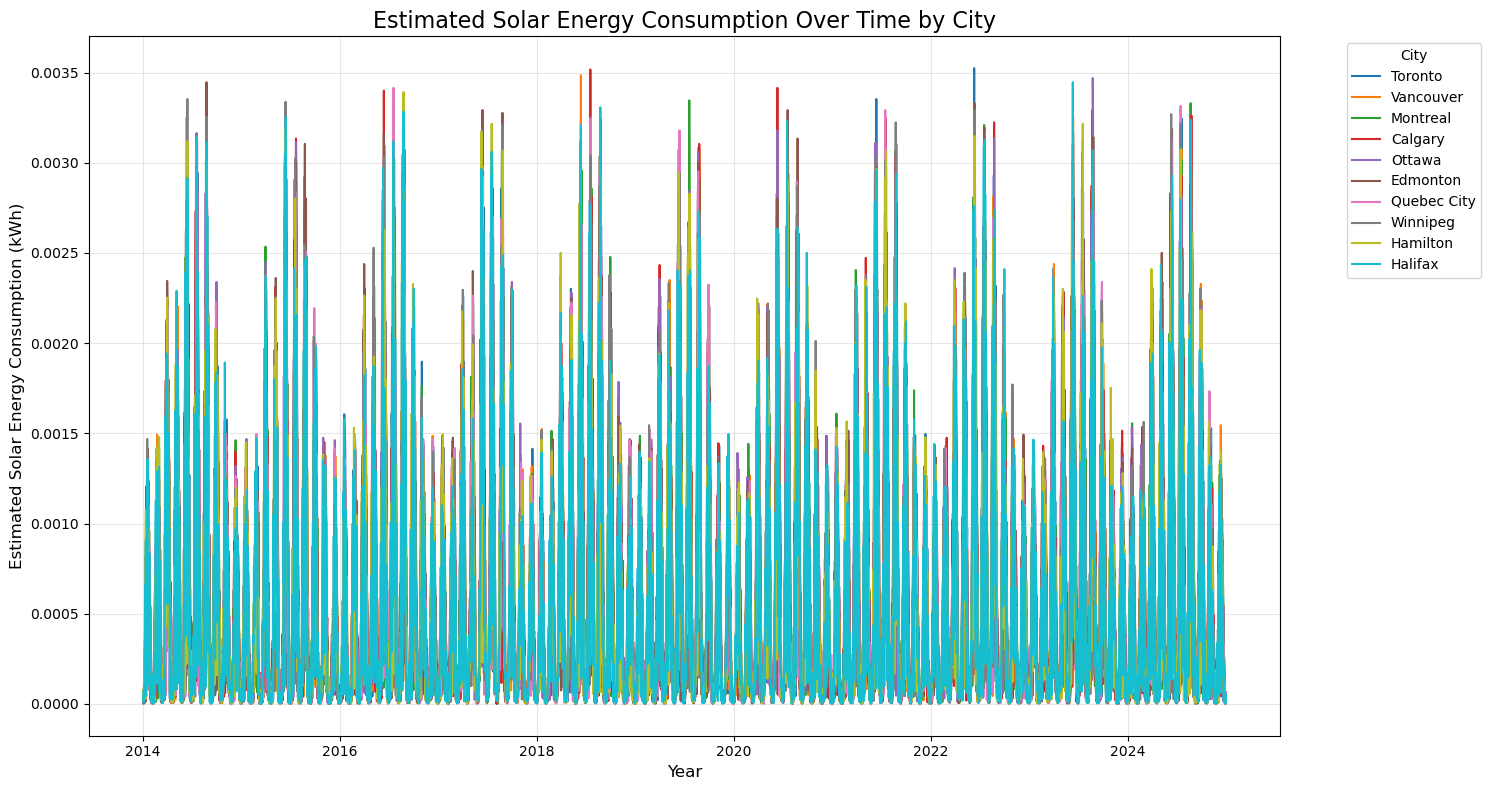

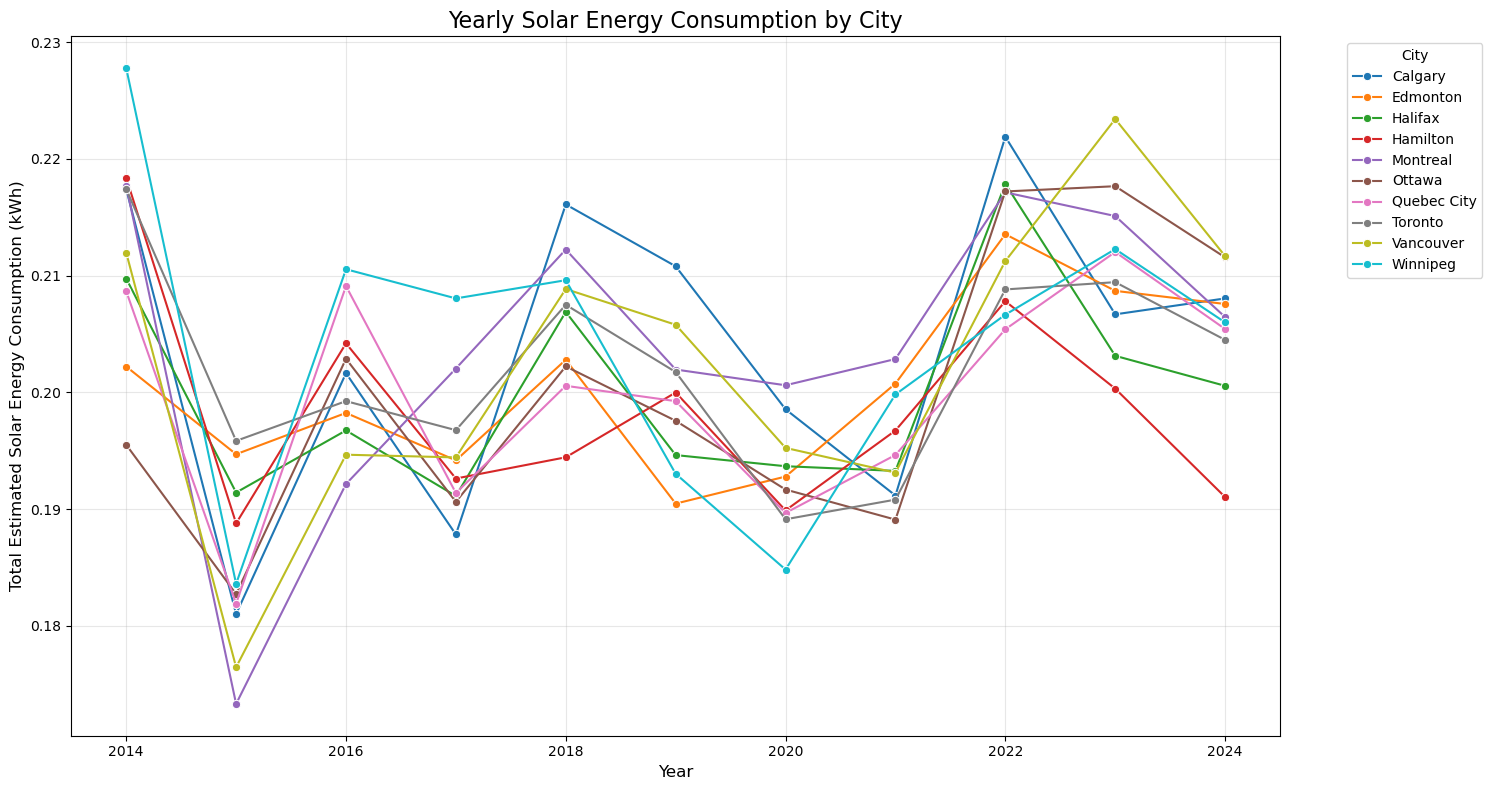

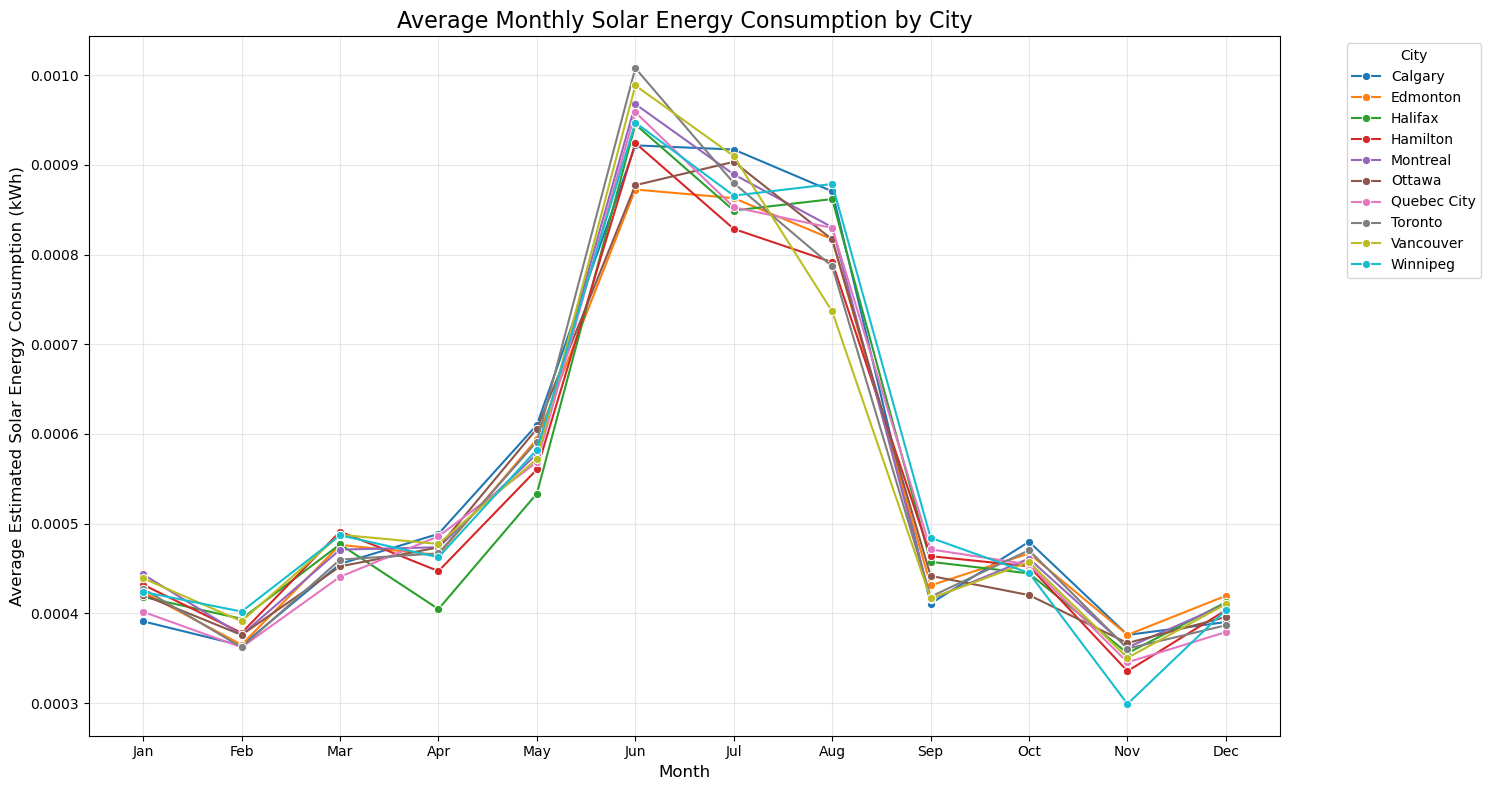

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
data = pd.read_csv('final_solar_weather_data_with_consumption.csv')

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Extract year and month for aggregation
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# 1. Time Series Plot for Each City
plt.figure(figsize=(15, 8))
sns.lineplot(data=data, x='Date', y='Estimated Solar Energy Consumption (kWh)', hue='City', ci=None)
plt.title('Estimated Solar Energy Consumption Over Time by City', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Estimated Solar Energy Consumption (kWh)', fontsize=12)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Annual Trends
annual_data = data.groupby(['Year', 'City'])['Estimated Solar Energy Consumption (kWh)'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.lineplot(data=annual_data, x='Year', y='Estimated Solar Energy Consumption (kWh)', hue='City', marker='o')
plt.title('Yearly Solar Energy Consumption by City', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Estimated Solar Energy Consumption (kWh)', fontsize=12)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Seasonal Trends
monthly_data = data.groupby(['Month', 'City'])['Estimated Solar Energy Consumption (kWh)'].mean().reset_index()

plt.figure(figsize=(15, 8))
sns.lineplot(data=monthly_data, x='Month', y='Estimated Solar Energy Consumption (kWh)', hue='City', marker='o')
plt.title('Average Monthly Solar Energy Consumption by City', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Estimated Solar Energy Consumption (kWh)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




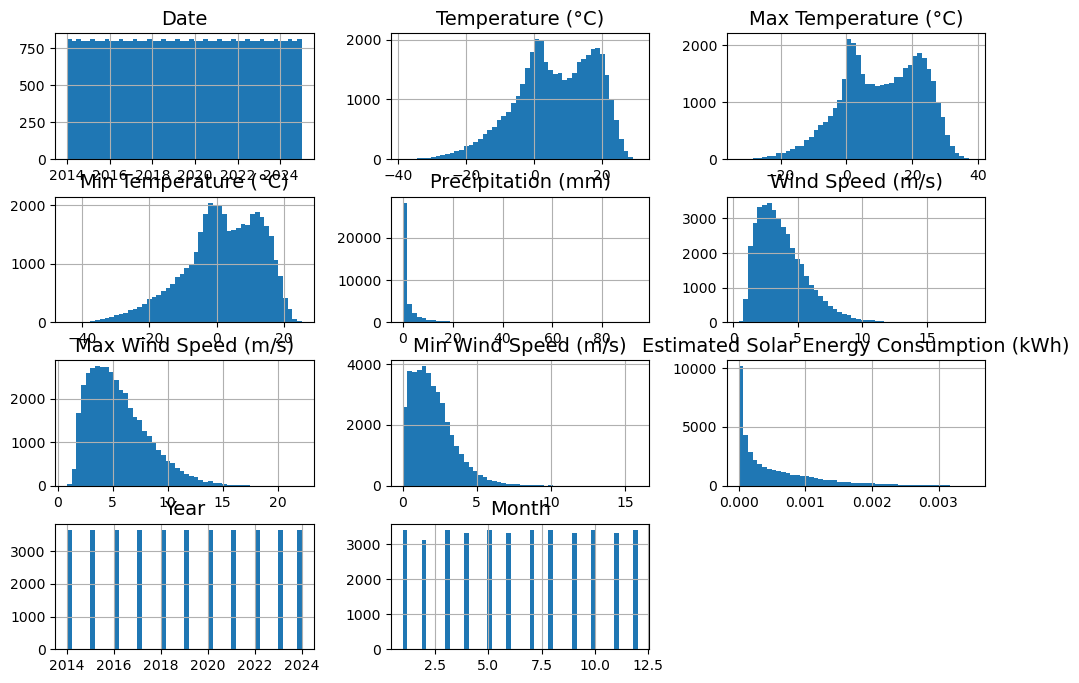

In [2]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

data.hist(bins=50, figsize=(12, 8))
plt.show()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40180 entries, 0 to 40179
Data columns (total 12 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      40180 non-null  datetime64[ns]
 1   City                                      40180 non-null  object        
 2   Temperature (°C)                          40180 non-null  float64       
 3   Max Temperature (°C)                      40180 non-null  float64       
 4   Min Temperature (°C)                      40180 non-null  float64       
 5   Precipitation (mm)                        40180 non-null  float64       
 6   Wind Speed (m/s)                          40180 non-null  float64       
 7   Max Wind Speed (m/s)                      40180 non-null  float64       
 8   Min Wind Speed (m/s)                      40180 non-null  float64       
 9   Estimated Solar Energy Consu

In [4]:
#no missing values

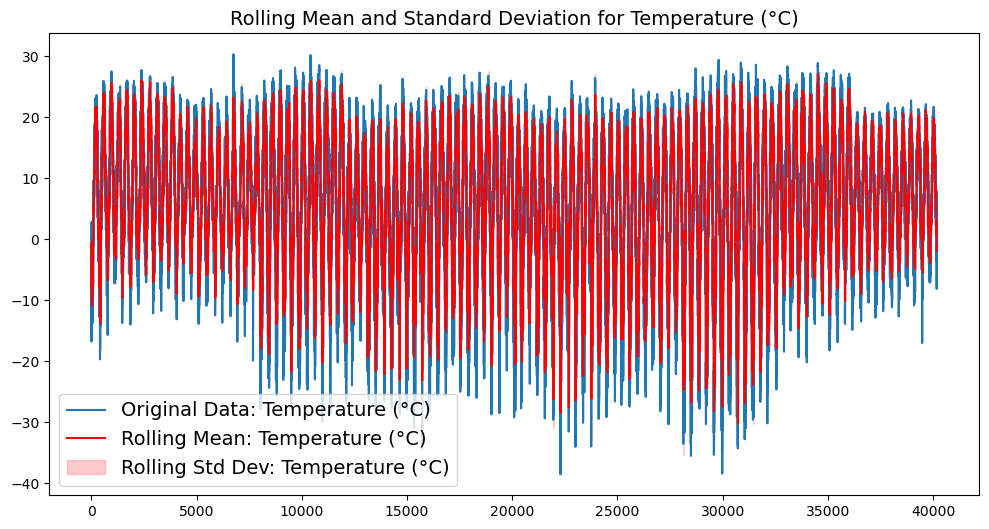

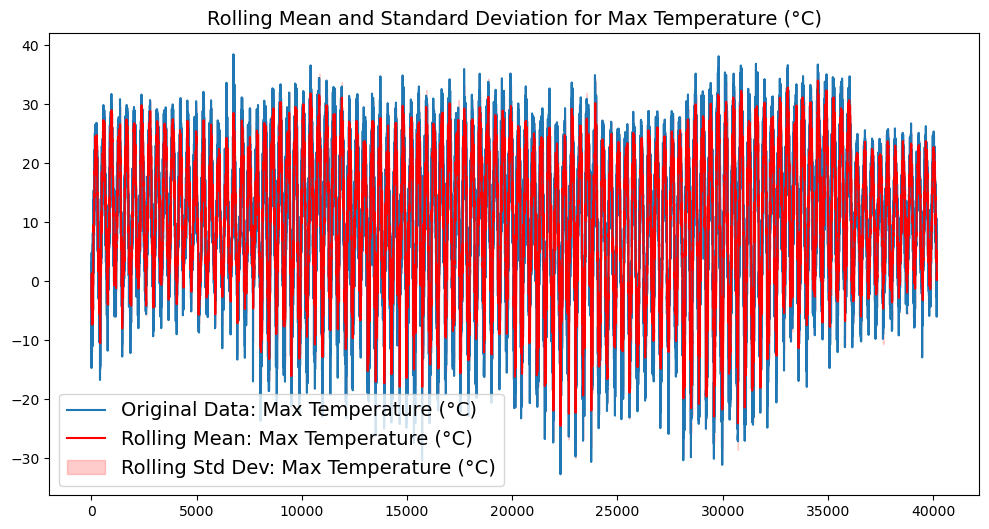

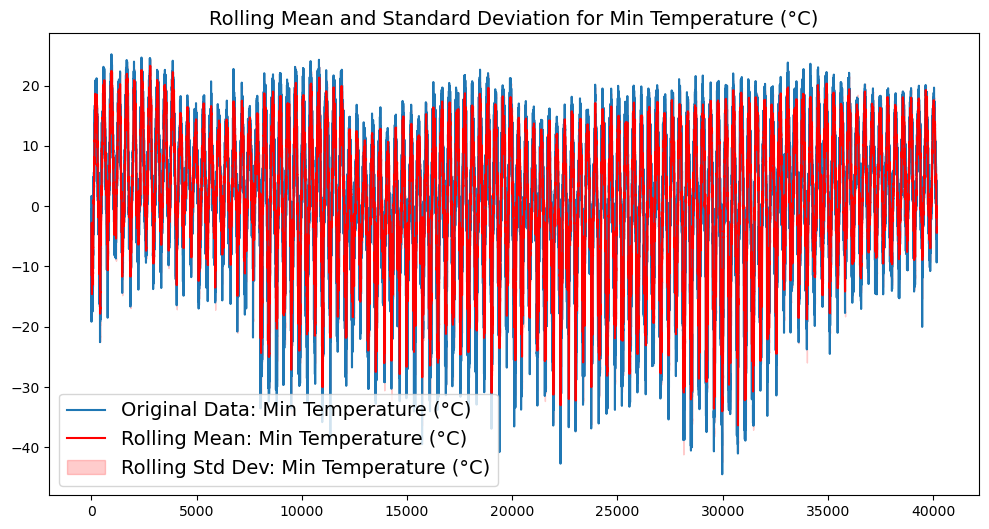

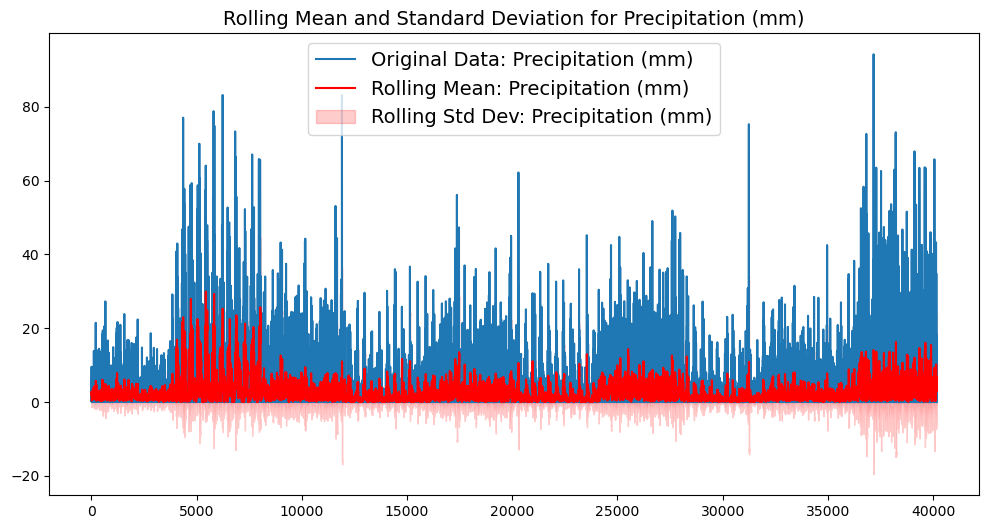

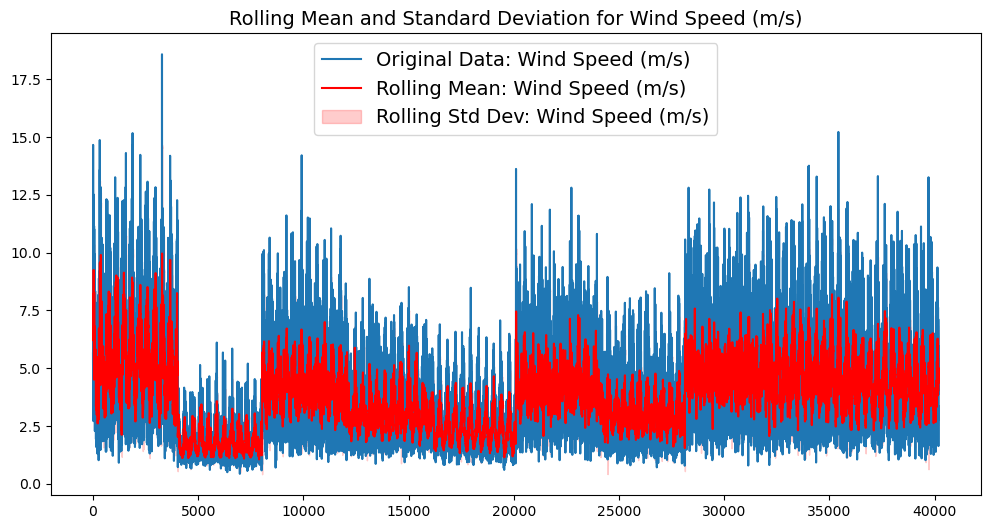

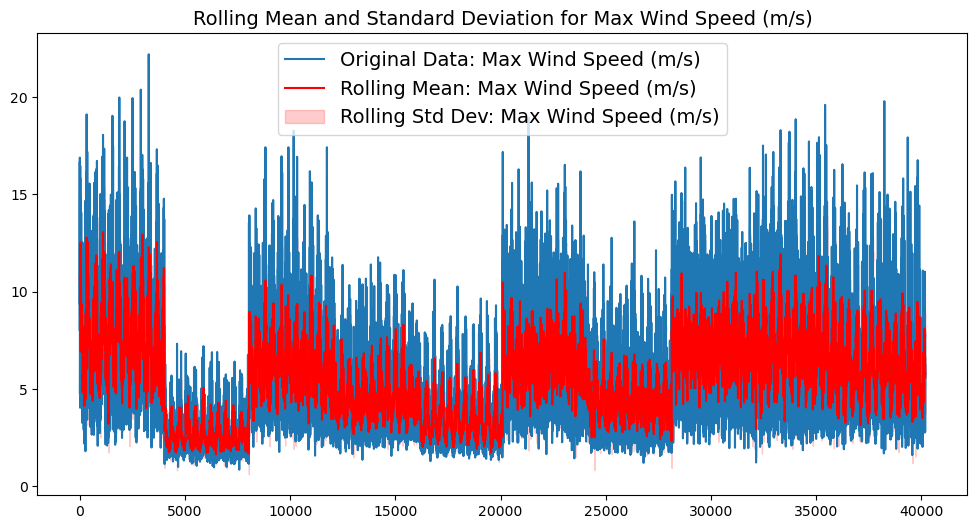

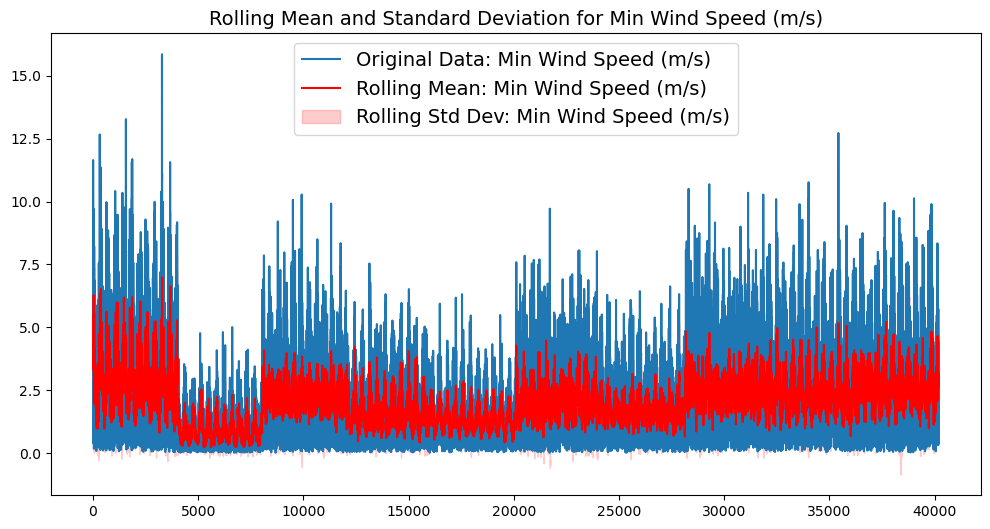

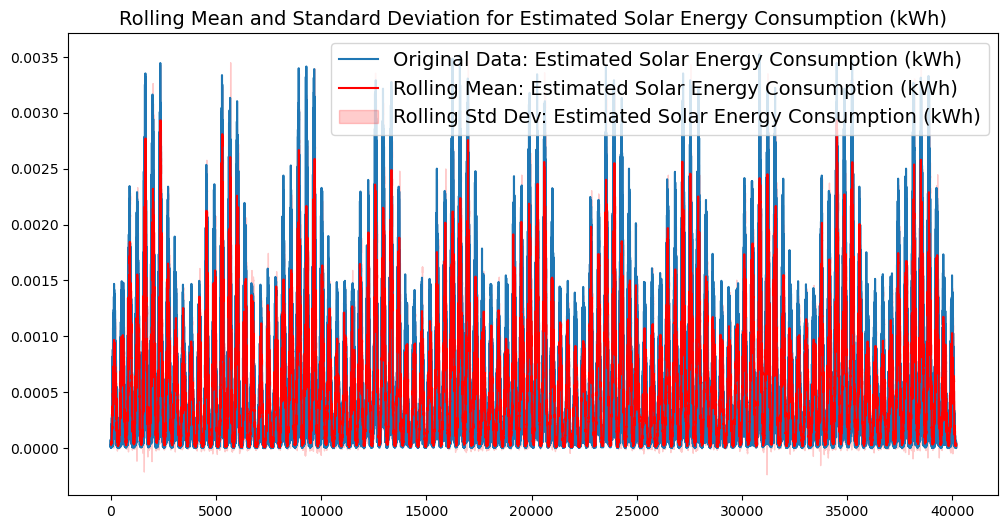

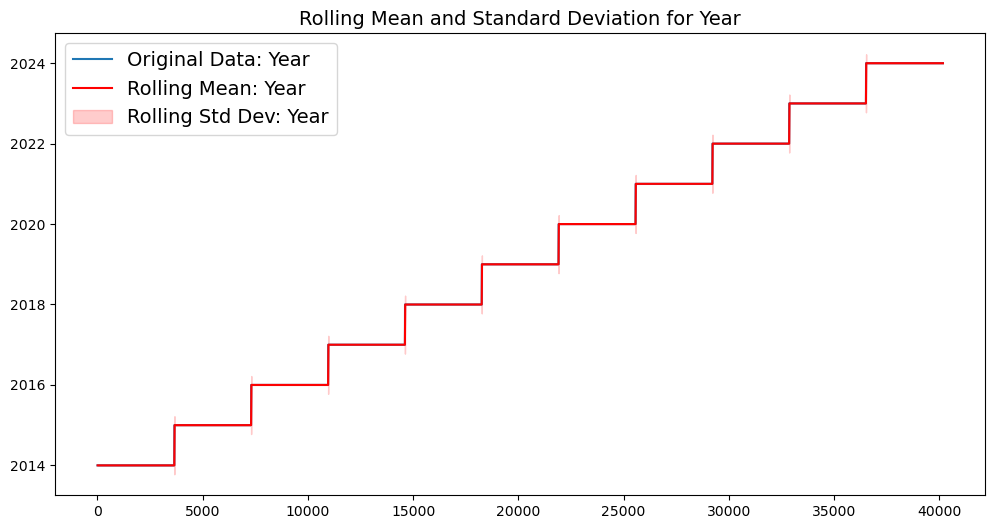

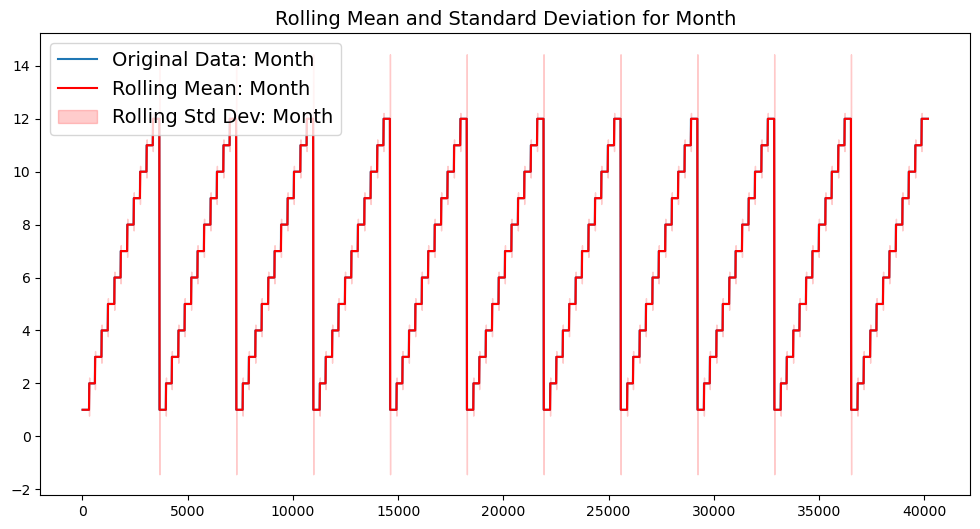

In [5]:
#outlier test
#rolling statistics

# Select only numerical columns excluding 'data'
numerical_columns = data.select_dtypes(include=['number']).columns
exclude_columns = ['data']  # Add any other columns you want to exclude
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

# Create a rolling mean and standard deviation for each numerical column
rolling_stats = {}
for col in numerical_columns:
    rolling_stats[col] = {
        'mean': data[col].rolling(window=10).mean(),
        'std': data[col].rolling(window=10).std()
    }

# Plot rolling mean and standard deviation for each numerical column
for col in numerical_columns:
    rolling_mean = rolling_stats[col]['mean']
    rolling_std = rolling_stats[col]['std']

    plt.figure(figsize=(12, 6))
    plt.plot(data[col], label=f'Original Data: {col}')
    plt.plot(rolling_mean, label=f'Rolling Mean: {col}', color='red')
    plt.fill_between(range(len(data)), rolling_mean - rolling_std, rolling_mean + rolling_std, 
                     color='red', alpha=0.2, label=f'Rolling Std Dev: {col}')
    plt.legend()
    plt.title(f'Rolling Mean and Standard Deviation for {col}')
    plt.show()


In [6]:
#visually, abrupt spikes in blue indicates outliers
#but since solar energy usage is being predicted based on season and seasonality is important here, I need to evaluate weather outliers need to be dropped or not


In [7]:
import pandas as pd
import numpy as np



# Exclude non-numerical columns and specific columns like 'Year' and 'Month'
numerical_data = data.select_dtypes(include=[np.number]).drop(columns=['Year', 'Month'], errors='ignore')

# Calculate Z-scores for the numerical columns
z_scores = (numerical_data - numerical_data.mean()) / numerical_data.std()

# Identify outliers (absolute Z-score > 3)
outliers = (z_scores.abs() > 3)

# Get the rows with outliers
outlier_rows = data[outliers.any(axis=1)]

# Output
print(f"Number of outliers detected: {len(outlier_rows)}")
print(outlier_rows)

# Save outliers to a file for further inspection (optional)
outlier_rows.to_csv('outliers_detected.csv', index=False)


Number of outliers detected: 2662
            Date         City  Temperature (°C)  Max Temperature (°C)  \
1     2014-01-01    Vancouver            -12.79                 -9.74   
3     2014-01-01      Calgary             -2.68                  0.19   
5     2014-01-01     Edmonton             -6.22                  3.20   
6     2014-01-01  Quebec City            -16.78                -14.68   
7     2014-01-01     Winnipeg             -9.87                 -6.87   
...          ...          ...               ...                   ...   
40101 2024-12-24    Vancouver             13.93                 17.05   
40131 2024-12-27    Vancouver              2.28                  3.84   
40132 2024-12-27     Montreal              2.75                  4.57   
40141 2024-12-28    Vancouver              8.13                  9.70   
40153 2024-12-29      Calgary              4.63                  8.31   

       Min Temperature (°C)  Precipitation (mm)  Wind Speed (m/s)  \
1                   

In [8]:
#there are 2662 outliers which is a huge number 
#but because of the nature of time series data and the fact that ARIMA is robust to outliers, I am choosing to keep as 
#most likely they account for seasonality



In [9]:
#one hot encoding categorical values (city)
#displaying all categorical variables
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col not in ['Year', 'Month']]
print("Categorical Columns:", categorical_columns)


Categorical Columns: ['City']


In [10]:
# One-hot encode the categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

print("Shape after one-hot encoding:", data_encoded.shape)


Shape after one-hot encoding: (40180, 20)


In [11]:

#feature scaling

from sklearn.preprocessing import StandardScaler

# Drop datetime columns for scaling
data_encoded_numeric = data_encoded.select_dtypes(include=['float64', 'int64'])

# Initialize scaler
scaler = StandardScaler()

# Scale only the numeric columns
data_scaled = scaler.fit_transform(data_encoded_numeric)

# Convert back to a DataFrame
import pandas as pd
data_scaled_df = pd.DataFrame(data_scaled, columns=data_encoded_numeric.columns, index=data_encoded.index)

# Combine scaled numeric columns with the original datetime column
data_encoded_scaled = pd.concat([data_encoded.select_dtypes(include=['datetime64']), data_scaled_df], axis=1)




In [12]:
len(data_encoded_scaled)

40180

Source: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8


In [13]:
#considering the above source link for splitting time series data and cross validating, have set a training window of 30 days and a test window of 7 days

In [14]:
import pandas as pd
from datetime import timedelta

# Assuming your DataFrame is 'data_encoded_scaled' and it is sorted by date
data_encoded_scaled = data_encoded_scaled.sort_values(by='Date')

# Set a time period for training and testing (e.g., 30 days for training, 7 days for testing)
train_period = timedelta(days=30)
test_period = timedelta(days=7)

# Initialize the start date for the first split
start_date = data_encoded_scaled['Date'].min()

# List to store train/test splits
train_test_splits = []

while start_date + train_period + test_period <= data_encoded_scaled['Date'].max():
    end_train_date = start_date + train_period
    end_test_date = end_train_date + test_period
    
    # Define the training and testing sets based on the date range
    train_set = data_encoded_scaled[(data_encoded_scaled['Date'] >= start_date) & (data_encoded_scaled['Date'] < end_train_date)]
    test_set = data_encoded_scaled[(data_encoded_scaled['Date'] >= end_train_date) & (data_encoded_scaled['Date'] < end_test_date)]
    
    # Store the splits
    train_test_splits.append((train_set, test_set))
    
    # Update the start date for the next split
    start_date = end_test_date

# Example of accessing the first train/test split
first_train_set, first_test_set = train_test_splits[0]
print(f"Training data from {first_train_set['Date'].min()} to {first_train_set['Date'].max()}")
print(f"Test data from {first_test_set['Date'].min()} to {first_test_set['Date'].max()}")

print(len(train_test_splits))


Training data from 2014-01-01 00:00:00 to 2014-01-30 00:00:00
Test data from 2014-01-31 00:00:00 to 2014-02-06 00:00:00
108


In [15]:
data_encoded_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40180 entries, 0 to 40179
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      40180 non-null  datetime64[ns]
 1   Temperature (°C)                          40180 non-null  float64       
 2   Max Temperature (°C)                      40180 non-null  float64       
 3   Min Temperature (°C)                      40180 non-null  float64       
 4   Precipitation (mm)                        40180 non-null  float64       
 5   Wind Speed (m/s)                          40180 non-null  float64       
 6   Max Wind Speed (m/s)                      40180 non-null  float64       
 7   Min Wind Speed (m/s)                      40180 non-null  float64       
 8   Estimated Solar Energy Consumption (kWh)  40180 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
m

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize a list to store performance metrics (MSE for each split)
performance_metrics = []

# Iterate over each train/test split
for train_set, test_set in train_test_splits:
    # Features and target variable for training and testing
    X_train = train_set[['Temperature (°C)', 'Max Temperature (°C)', 'Min Temperature (°C)', 
                         'Precipitation (mm)', 'Wind Speed (m/s)', 'Max Wind Speed (m/s)', 
                         'Min Wind Speed (m/s)']]  # Use the appropriate features
    y_train = train_set['Estimated Solar Energy Consumption (kWh)']
    
    X_test = test_set[['Temperature (°C)', 'Max Temperature (°C)', 'Min Temperature (°C)', 
                       'Precipitation (mm)', 'Wind Speed (m/s)', 'Max Wind Speed (m/s)', 
                       'Min Wind Speed (m/s)']]  # Use the appropriate features
    y_test = test_set['Estimated Solar Energy Consumption (kWh)']
    
    # Initialize the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_test)
    
    # Calculate performance (mean squared error as an example)
    mse = mean_squared_error(y_test, y_pred)
    performance_metrics.append(mse)

# Print performance metrics
print(f"Mean Squared Errors for each split: {performance_metrics}")
print(f"Average Mean Squared Error: {sum(performance_metrics)/len(performance_metrics)}")


Mean Squared Errors for each split: [0.16584641491410465, 0.23211504230518878, 0.4674778643891999, 0.30261166839314574, 0.49895827405561693, 0.5231147421255087, 0.5470140360962774, 0.23273971561090184, 0.2795144910966202, 0.1046262764259114, 0.2800486260046566, 0.03227358426828846, 0.015518495501869926, 0.026494870431950396, 0.07400985097403923, 0.12960058080901898, 0.13166183108262802, 0.03561643846836693, 0.05599834720814808, 0.02358258527418094, 0.04318614710967182, 0.5922933219033969, 0.6393005487634048, 1.9707982390412524, 0.9685141890169772, 1.191428227963923, 0.6646867965721268, 0.9223132118411006, 0.2656674778289809, 0.4701376322571358, 0.5312396854894327, 1.2873263572630222, 0.9879423426353287, 3.482226130102628, 2.12225216537906, 1.4217094196479312, 0.8101891755445777, 0.3036273846285734, 0.4097425825594031, 0.45785141386773154, 0.44495715391466995, 1.4079989711932972, 1.424836717856891, 2.627314536041267, 2.216849070494805, 2.6853617017491764, 0.9567614575099667, 0.441844950

In [20]:
import numpy as np

# Assuming `train_test_splits` contains your train and test data
# we will use the first split for demonstration purposes
train_set, test_set = train_test_splits[0]


y_true = test_set['Estimated Solar Energy Consumption (kWh)']


y_pred = rf.predict(test_set.drop(columns=['Date', 'Estimated Solar Energy Consumption (kWh)']))

# Get the min and max values for actual and predicted values
min_actual = y_true.min()
max_actual = y_true.max()
min_pred = np.min(y_pred)
max_pred = np.max(y_pred)

print(f"Range of Actual Values: {min_actual} to {max_actual}")
print(f"Range of Predicted Values: {min_pred} to {max_pred}")


Range of Actual Values: -0.871645655154819 to -0.5016111726419024
Range of Predicted Values: -0.8581342009892718 to -0.25140538890296965


seeing range of predicted and actual values, 0.69 MSE seems like a good accuracy measure.

In [22]:
#Fine tune hyperparameters for better performance
#using grid search and manually iterating over custom train-test splits to tune hyperparamters

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf']
))

# Initialize variables to store best results
best_params = None
best_mse = float('inf')

# Iterate over each hyperparameter combination
for params in param_combinations:
    n_estimators, max_depth, min_samples_split, min_samples_leaf = params
    performance_metrics = []
    
    # Iterate over each train/test split
    for train_set, test_set in train_test_splits:
        # Features and target variable for training and testing
        X_train = train_set[['Temperature (°C)', 'Max Temperature (°C)', 'Min Temperature (°C)', 
                             'Precipitation (mm)', 'Wind Speed (m/s)', 'Max Wind Speed (m/s)', 
                             'Min Wind Speed (m/s)']]  # Use the appropriate features
        y_train = train_set['Estimated Solar Energy Consumption (kWh)']
        
        X_test = test_set[['Temperature (°C)', 'Max Temperature (°C)', 'Min Temperature (°C)', 
                           'Precipitation (mm)', 'Wind Speed (m/s)', 'Max Wind Speed (m/s)', 
                           'Min Wind Speed (m/s)']]  # Use the appropriate features
        y_test = test_set['Estimated Solar Energy Consumption (kWh)']
        
        # Initialize the RandomForestRegressor with current parameters
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        
        # Train the model
        rf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = rf.predict(X_test)
        
        # Calculate performance (mean squared error as an example)
        mse = mean_squared_error(y_test, y_pred)
        performance_metrics.append(mse)
    
    # Calculate average MSE for this parameter combination
    avg_mse = np.mean(performance_metrics)
    print(f"Params: {params}, Average MSE: {avg_mse}")
    
    # Update best parameters if current MSE is lower
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_params = params

# Print the best hyperparameters and corresponding MSE
print(f"Best Parameters: {best_params}")
print(f"Best Average MSE: {best_mse}")






Params: (100, 10, 2, 1), Average MSE: 0.6983282201457537
Params: (100, 10, 2, 2), Average MSE: 0.6901262883957185
Params: (100, 10, 2, 4), Average MSE: 0.6881364461348752
Params: (100, 10, 5, 1), Average MSE: 0.6954487147200651
Params: (100, 10, 5, 2), Average MSE: 0.6909976879443623
Params: (100, 10, 5, 4), Average MSE: 0.6881364461348752
Params: (100, 10, 10, 1), Average MSE: 0.6937316582325986
Params: (100, 10, 10, 2), Average MSE: 0.6905008702892389
Params: (100, 10, 10, 4), Average MSE: 0.687185560428947
Params: (100, 20, 2, 1), Average MSE: 0.6966410749093096
Params: (100, 20, 2, 2), Average MSE: 0.6902585210362351
Params: (100, 20, 2, 4), Average MSE: 0.6880372870622448
Params: (100, 20, 5, 1), Average MSE: 0.6953289329124104
Params: (100, 20, 5, 2), Average MSE: 0.6910610433818943
Params: (100, 20, 5, 4), Average MSE: 0.6880372870622448
Params: (100, 20, 10, 1), Average MSE: 0.6935974374712595
Params: (100, 20, 10, 2), Average MSE: 0.6905487423898938
Params: (100, 20, 10, 4), A

Best Parameters: (300, 20, 10, 4)
Best Average MSE: 0.6843661990962608

hyperparameter tuning takes 23 minutes to run

VISUALIZATIONS

In [24]:
#pip install geopandas folium matplotlib


Note: you may need to restart the kernel to use updated packages.


average solar energy consumption

In [26]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap

# Cities and their coordinates
cities = {
    'Toronto': {'lat': 43.7, 'lon': -79.42},
    'Vancouver': {'lat': 49.28, 'lon': -123.12},
    'Montreal': {'lat': 45.50, 'lon': -73.58},
    'Calgary': {'lat': 51.05, 'lon': -114.07},
    'Ottawa': {'lat': 45.42, 'lon': -75.69},
    'Edmonton': {'lat': 53.55, 'lon': -113.49},
    'Quebec City': {'lat': 46.81, 'lon': -71.21},
    'Winnipeg': {'lat': 49.89, 'lon': -97.14},
    'Hamilton': {'lat': 43.26, 'lon': -79.87},
    'Halifax': {'lat': 44.65, 'lon': -63.57}
}

# Example data: Average solar energy consumption per city
city_data = {
    'Toronto': 2200,
    'Vancouver': 1900,
    'Montreal': 2100,
    'Calgary': 2500,
    'Ottawa': 2150,
    'Edmonton': 2400,
    'Quebec City': 2000,
    'Winnipeg': 2300,
    'Hamilton': 2250,
    'Halifax': 1800
}

# Create a DataFrame from the cities
city_df = pd.DataFrame({
    'City': cities.keys(),
    'Latitude': [cities[city]['lat'] for city in cities],
    'Longitude': [cities[city]['lon'] for city in cities],
    'Avg Solar Energy Consumption': [city_data[city] for city in cities]
})

# Create a map centered on Canada
canada_map = folium.Map(location=[56.1304, -106.3468], zoom_start=4)

# Add circles to the map for each city
for _, row in city_df.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=row['Avg Solar Energy Consumption'] / 300,  # Adjust scale as needed
        color='blue',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7,
        tooltip=f"{row['City']}: {row['Avg Solar Energy Consumption']} kWh"
    ).add_to(canada_map)

# Save or display the map
canada_map.save('canadian_solar_energy_map.html')
canada_map


EXTRA : trying ARIMA 

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse


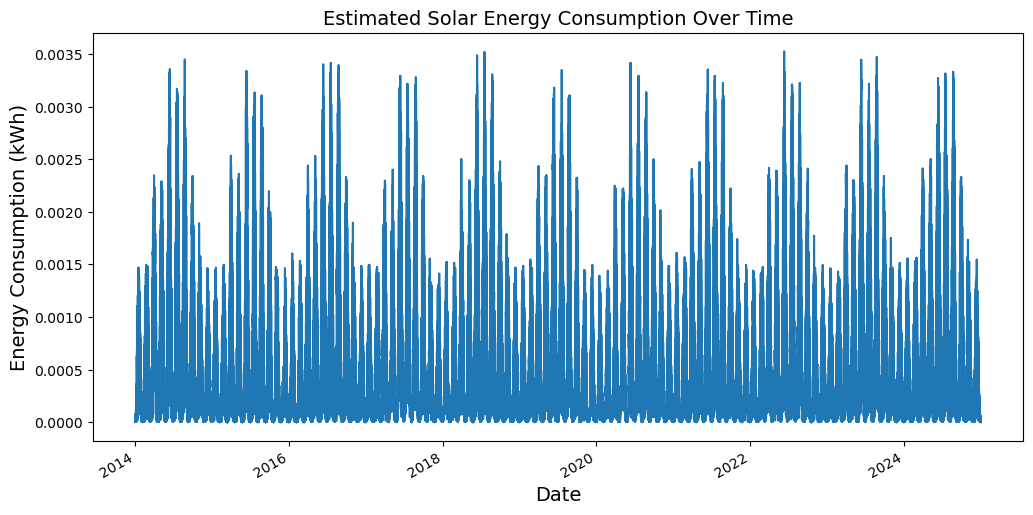

In [32]:
# Load dataset
data = pd.read_csv("final_solar_weather_data_with_consumption.csv")

# Convert 'Date' column to datetime type and set it as the index
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)

# Focus on the 'Estimated Solar Energy Consumption (kWh)' column for forecasting
data = data["Estimated Solar Energy Consumption (kWh)"]

# Plot the time series to inspect the data
data.plot(figsize=(12, 6))
plt.title("Estimated Solar Energy Consumption Over Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()


In [33]:
from statsmodels.tsa.stattools import adfuller

# ADF test
result = adfuller(data.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If the p-value is less than 0.05, the series is stationary.


ADF Statistic: -16.738921761494964
p-value: 1.3634010536406932e-29


since p-value is much lower than 0.05, the time series is stationary, hence differencing the data is not required.

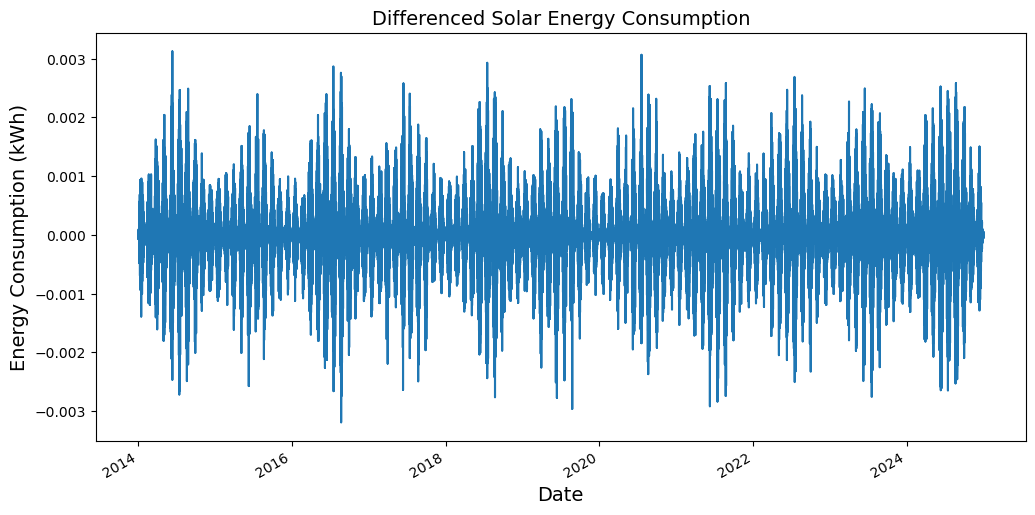

In [34]:
# Differencing to make the series stationary
data_diff = data.diff().dropna()

# Plot the differenced series
data_diff.plot(figsize=(12, 6))
plt.title("Differenced Solar Energy Consumption")
plt.ylabel("Energy Consumption (kWh)")
plt.show()


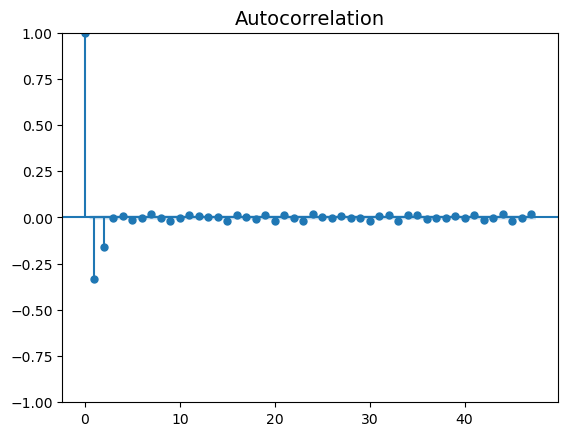

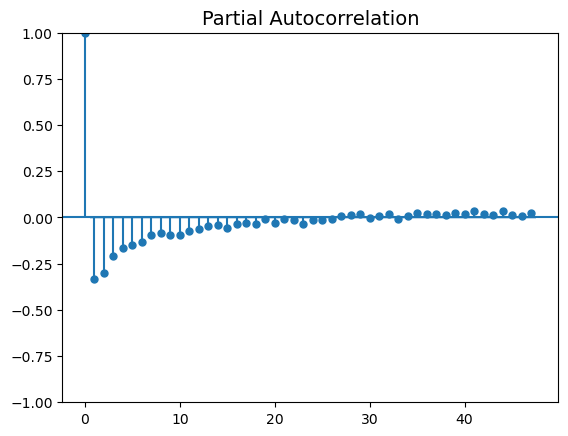

In [38]:
# ACF and PACF plots to identify q and p
plot_acf(data_diff)
plot_pacf(data_diff)
plt.show()


In [35]:
# Fit ARIMA model (for example, with p=1, d=1, q=1)
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())


/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                          SARIMAX Results                                           
Dep. Variable:     Estimated Solar Energy Consumption (kWh)   No. Observations:                40180
Model:                                       ARIMA(1, 1, 1)   Log Likelihood              257749.672
Date:                                      Sun, 19 Jan 2025   AIC                        -515493.343
Time:                                              15:54:50   BIC                        -515467.540
Sample:                                                   0   HQIC                       -515485.178
                                                    - 40180                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3622      0.004  

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


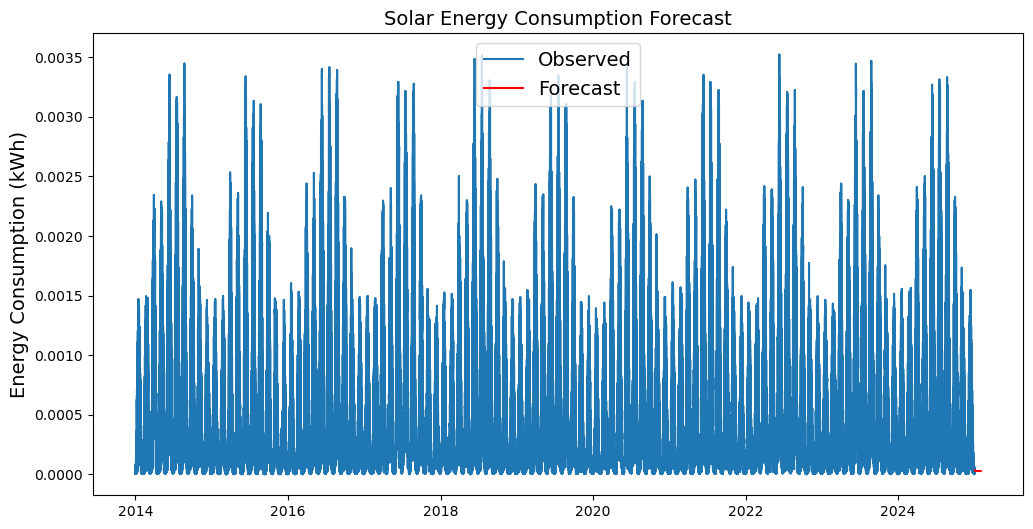

In [36]:
# Forecasting the next 30 days
forecast = model_fit.forecast(steps=30)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label="Observed")
plt.plot(pd.date_range(start=data.index[-1], periods=31, freq='D')[1:], forecast, label="Forecast", color='red')
plt.legend()
plt.title("Solar Energy Consumption Forecast")
plt.ylabel("Energy Consumption (kWh)")
plt.show()


In [37]:
# Calculate RMSE (Root Mean Squared Error)
forecast_errors = forecast - data[-30:].values
print(f"RMSE: {rmse(data[-30:].values, forecast)}")


RMSE: 2.3954418763649348e-05


In [ ]:
#This dataset worked better with a random forest regression model than an ARIMA model even though it was a time-series dataset.